In [1]:
!pip install opencv-python
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

In [2]:
feature_extraction_algo = 'sift'

feature_to_match = 'bf'

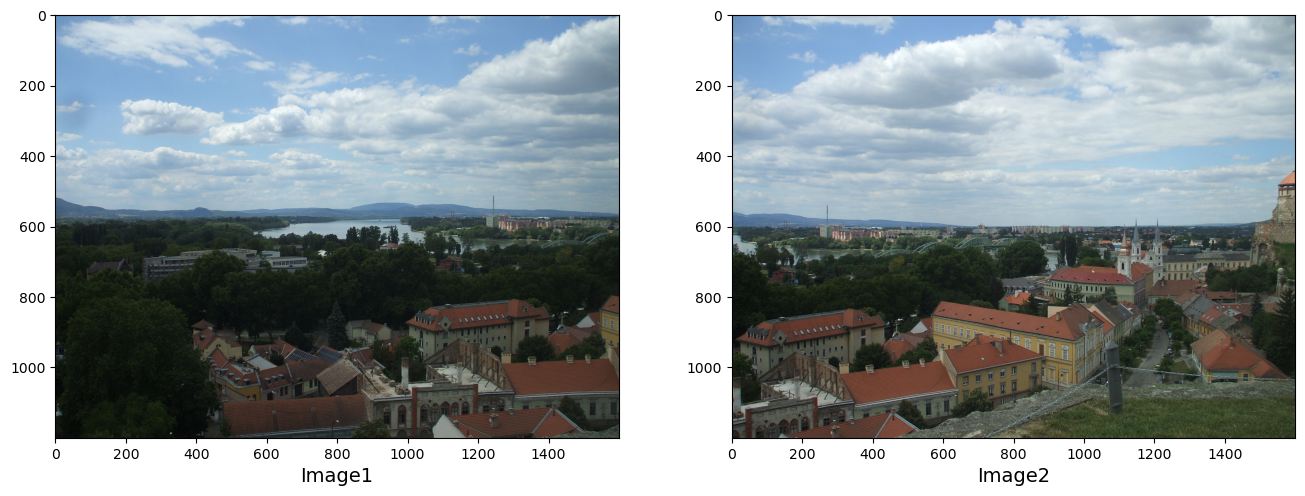

In [3]:
image1 = cv.imread('D:/Image_Striching/1/DSCF8688.jpg')
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)

image2 = cv.imread('D:/Image_Striching/1/DSCF8689.jpg')
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), constrained_layout=False)

# Display images
ax2.imshow(image2, cmap='gray')  # Fixed "camp" typo to "cmap"
ax2.set_xlabel('Image2', fontsize=14)
ax1.imshow(image1, cmap='gray')  # Fixed "camp" typo to "cmap"
ax1.set_xlabel('Image1', fontsize=14)

plt.show()

In [7]:
def select_descriptor_method(image, method=None):
    
    assert method is not None, "Please define a description method. Accepted values are: 'sift', 'surf', 'orb', 'brisk' "

    if method == 'sift':
        descriptor = cv.SIFT_create()
        
    if method == 'surf':
        descriptor = cv.SURF_create()
        
    if method == 'brisk':
        descriptor = cv.BRISK_create()
    
    if method == 'orb':
        descriptor = cv.ORB_create()

    (keypoints, features) = descriptor.detectAndCompute(image, None)

    return (keypoints, features)

In [13]:
keypoints_image2, feature_image2 = select_descriptor_method(image2_gray, method=feature_extraction_algo)
keypoints_image1, feature_image1 = select_descriptor_method(image1_gray, method=feature_extraction_algo)
# print('keypoints image2', keypoints_image2)
print('feature image2', feature_image2)

feature image2 [[29. 10.  2. ...  0.  0.  0.]
 [11.  1.  0. ... 33. 29. 16.]
 [30.  3.  0. ... 10.  9. 16.]
 ...
 [15.  1.  0. ...  1.  1.  2.]
 [ 0.  2. 21. ...  0.  0.  0.]
 [ 1.  0.  0. ...  2.  1.  0.]]


In [15]:
for keypoint in keypoints_image1:
    x, y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id
print("x, y", x, y)
print("size", size)
print("orientation", orientation)
print("response", response)
print("octave", octave)
print('class_id', class_id)

x, y 1596.0670166015625 930.5545043945312
size 1.9884687662124634
orientation 188.4117889404297
response 0.03019348904490471
octave 7340543
class_id -1


In [17]:
feature_image1.shape

(2574, 128)

In [19]:
len(feature_image1)

2574

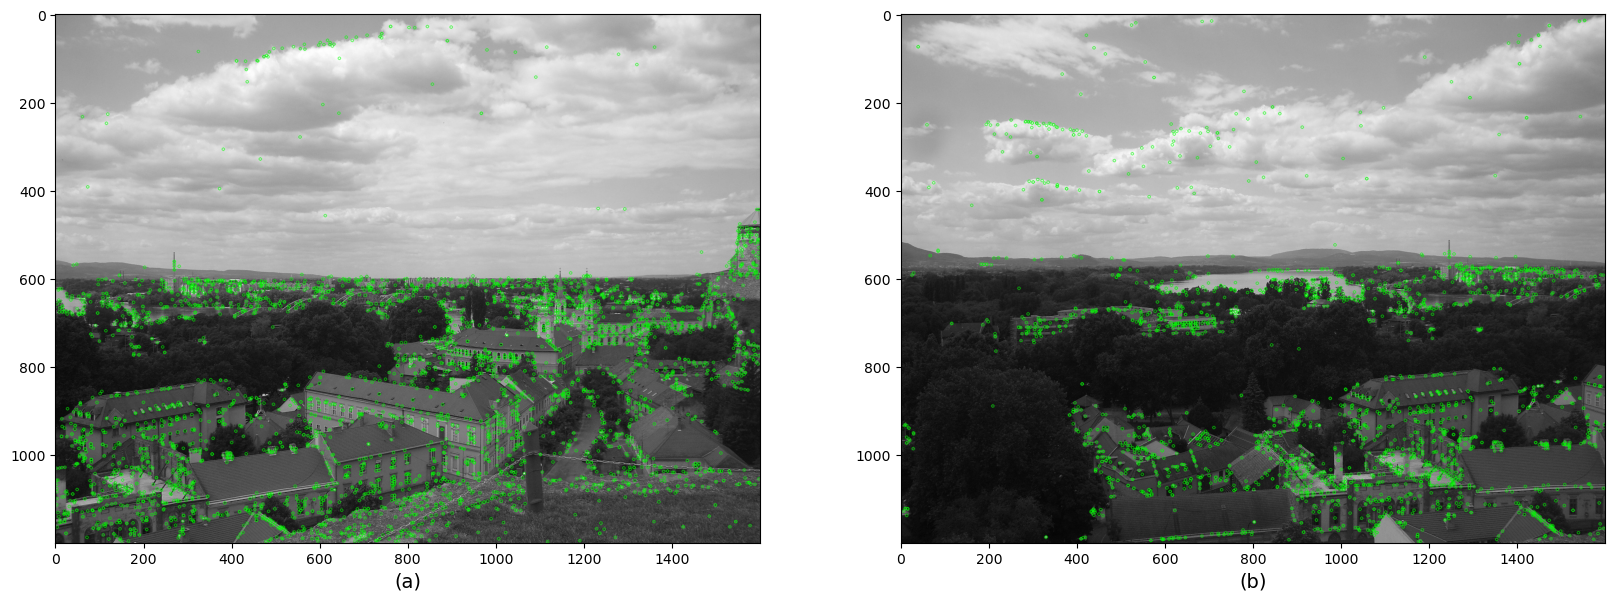

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), constrained_layout=False)

# Display the first image with keypoints
ax1.imshow(cv.drawKeypoints(image2_gray, keypoints_image2, None, color=(0, 255, 0)))
ax1.set_xlabel('(a)', fontsize=14)  # Corrected argument name to 'fontsize'

# Display the second image with keypoints
ax2.imshow(cv.drawKeypoints(image1_gray, keypoints_image1, None, color=(0, 255, 0)))
ax2.set_xlabel('(b)', fontsize=14)  # Corrected argument name to 'fontsize'

plt.savefig(
    'D:/Image_Striching/output/' + feature_extraction_algo + '_feature_img' + '.jpeg',
    bbox_inches='tight',
    dpi=300,
    format='jpeg'  # Ensure the format is explicitly specified as 'jpeg'
)
plt.show()



In [23]:
def create_matching_object(method, crossCheck):
    # crossCheck is a boolean parameter which is false by default. it indicate whethere the two features have to match each other to be considered valid
    # if it's true then matcher returns only those matches with value i,j such that "i"th descriptor in set "(a)" has "j"th descriptor in set "(b)" as best match and vice versa
    if method == 'sift' or method == 'surf':  
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=crossCheck) # for euclidean distance or l2 distance
    elif method == 'orb' or method == 'brisk':
        bf = cv.BFMatcher(cv.NORM_HAMING, crossCheck=crossCheck) # for haming distance
    
    return bf
    

In [25]:
def key_points_matching(feature_image2, feature_image1, method):
    bf = create_matching_object(method, crossCheck=True)
    best_matches = bf.match(feature_image2, feature_image1)
    raw_matches = sorted(best_matches, key = lambda x: x.distance)
    print('Raw matches with Brute Force', len(raw_matches))
    return raw_matches
    

In [27]:
def key_points_matching_KNN(feature_image2, feature_image1, ratio, method):
    bf = create_matching_object(method, crossCheck=False)
    raw_matches = bf.knnMatch(feature_image2, feature_image1, k=2)
    print('Raw matches with KNN', len(raw_matches))

    knn_matches = []
    for m, n in raw_matches:
        if m.distance < n.distance * ratio:
            knn_matches.append(m)
    return knn_matches
    

Drawing matched features for bf
Raw matches with Brute Force 1152


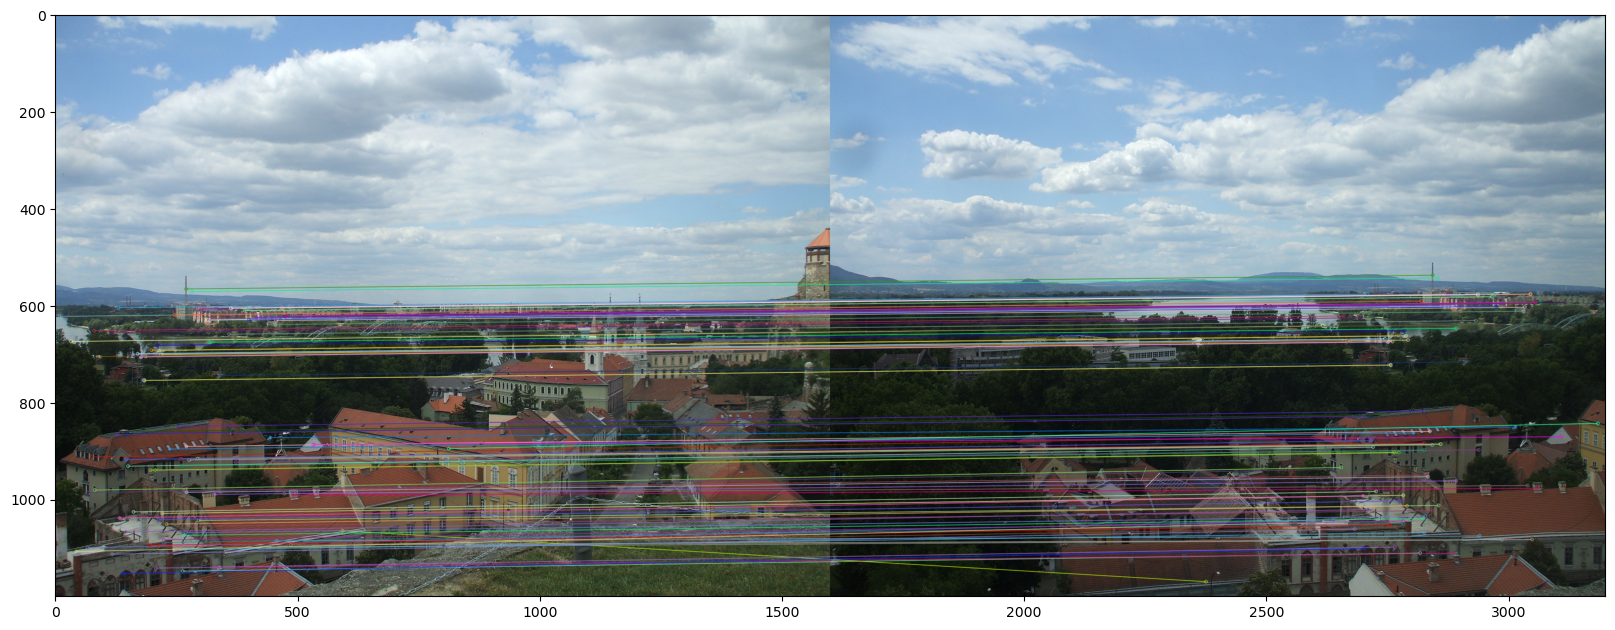

In [29]:
print('Drawing matched features for', feature_to_match)
fig = plt.figure(figsize=(20,8))
feature_to_match = 'bf'
if feature_to_match == 'bf':
    matches = key_points_matching(feature_image2, feature_image1, method=feature_extraction_algo)
    mapped_feature_image = cv.drawMatches(image2, keypoints_image2, image1, keypoints_image1, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(feature_image2, feature_image1, ratio=0.75, method=feature_extraction_algo)
    mapped_feature_image_knn = cv.drawMatches(image2, keypoints_image2, image1, keypoints_image1, np.random.choice(matches, 100), None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image) 


Drawing matched features for knn
Raw matches with KNN 4179


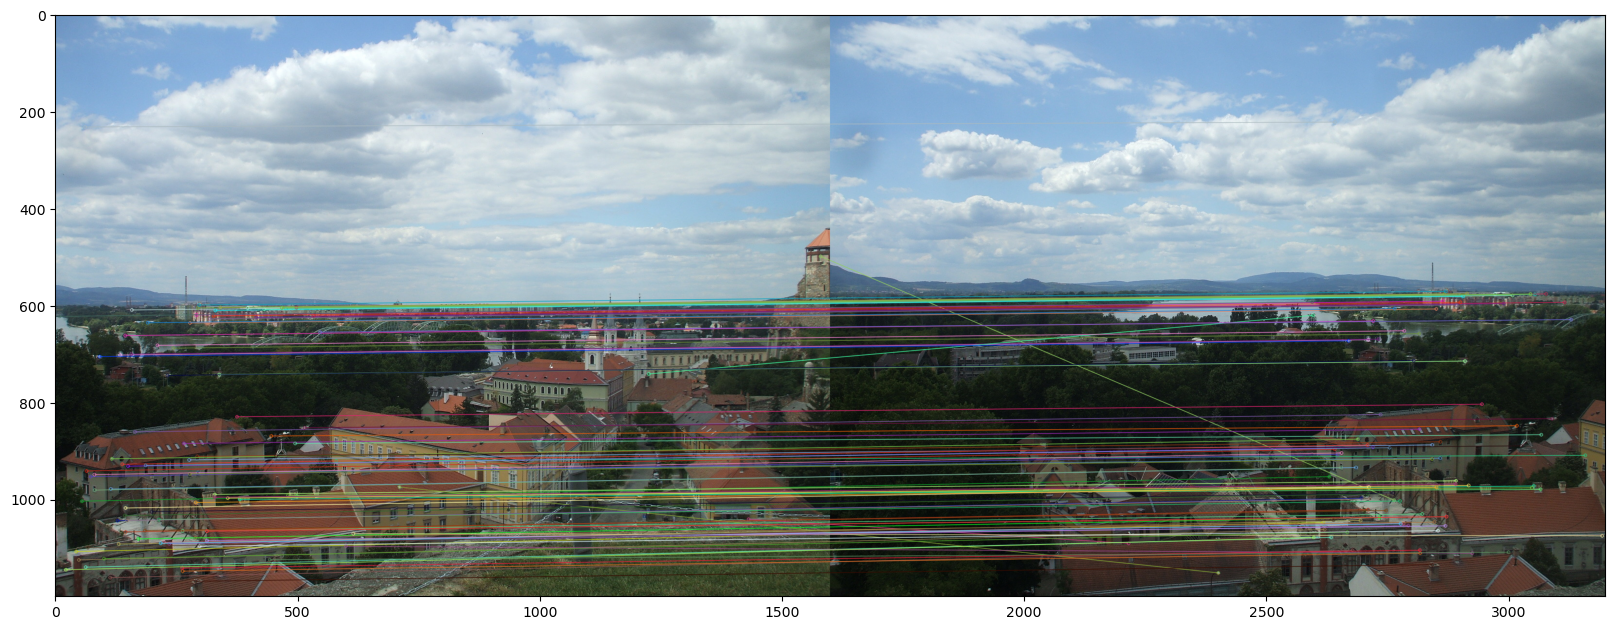

In [31]:
feature_to_match = 'knn'
print('Drawing matched features for', feature_to_match)
fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(feature_image2, feature_image1, method=feature_extraction_algo)
    mapped_feature_image = cv.drawMatches(image1, keypoints_image1, image2, keypoints_image2, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(feature_image2, feature_image1, ratio=0.75, method=feature_extraction_algo)
    mapped_feature_image_knn = cv.drawMatches(image2, keypoints_image2, image1, keypoints_image1, np.random.choice(matches, 100), None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image_knn)

In [33]:
def homography_stitching(keypoints_image2, keypoints_image1, matches, reprojThresh):
    keypoints_image2 = np.float32([keypoint.pt for keypoint in keypoints_image2])
    keypoints_image1 = np.float32([keypoint.pt for keypoint in keypoints_image1])

    if len(matches) > 4:
        points_image2 = np.float32([keypoints_image2[m.queryIdx] for m in matches])
        points_image1 = np.float32([keypoints_image1[m.trainIdx] for m in matches])
        (H, status) = cv.findHomography(points_image2, points_image1, cv.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None
        

In [35]:
M = homography_stitching(keypoints_image2, keypoints_image1, matches, reprojThresh=4)

if M is None:
    print('Error')
(matches, Homography_Matrix, status) = M
print(Homography_Matrix)

[[ 6.83655577e-01 -4.17642642e-03  1.00769890e+03]
 [-1.22606798e-01  9.66804302e-01 -5.34104081e-01]
 [-2.10730048e-04  2.19383418e-05  1.00000000e+00]]


In [37]:
width = image1.shape[1] + image2.shape[1]
print(width)

height = max(image1.shape[0], image2.shape[0])
print(height)

3200
1200


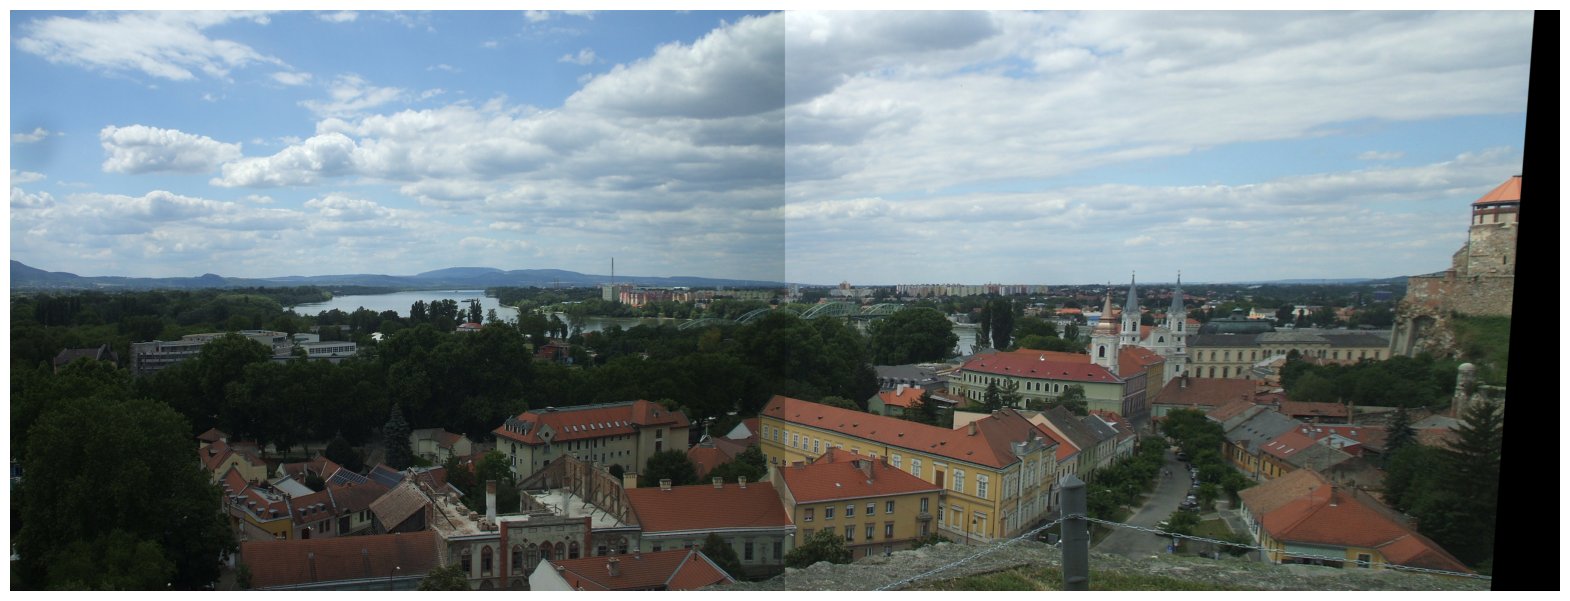

In [39]:
result = cv.warpPerspective(image2, Homography_Matrix, (width, height))
# print(result)
result[0:image1.shape[0], 0:image1.shape[1]] = image1

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(result)

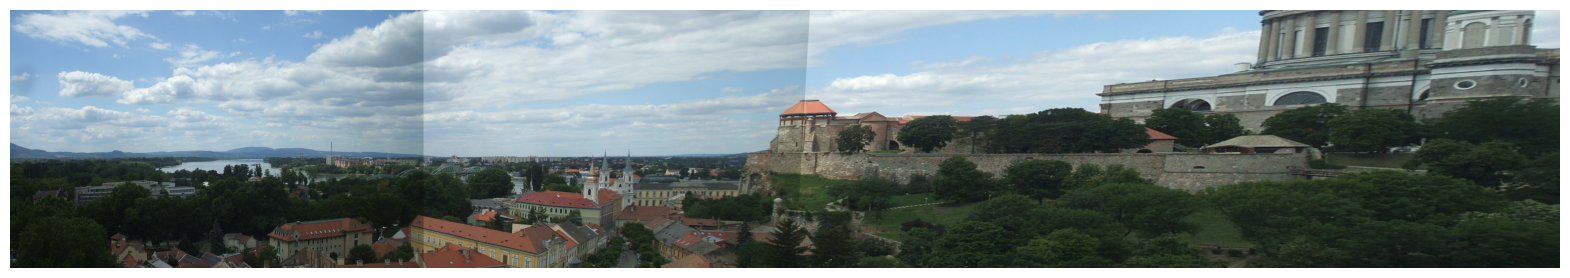

In [249]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
import imageio
cv.ocl.setUseOpenCL(False)
warnings.filterwarnings('ignore')

def select_descriptor_method(image, method=None):
    assert method is not None, "Please define a description method. Accepted values are: 'sift', 'surf', 'orb', 'brisk' "
    if method == 'sift':
        descriptor = cv.SIFT_create()
    elif method == 'surf':
        descriptor = cv.SURF_create()
    elif method == 'brisk':
        descriptor = cv.BRISK_create()
    elif method == 'orb':
        descriptor = cv.ORB_create()
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    return keypoints, features

def create_matching_object(method, crossCheck=True):
    if method == 'sift' or method == 'surf':  
        bf = cv.BFMatcher(cv.NORM_L2, crossCheck=crossCheck)  # for euclidean distance or l2 distance
    elif method == 'orb' or method == 'brisk':
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=crossCheck)  # for hamming distance
    return bf

def key_points_matching(feature_image2, feature_image1, method):
    bf = create_matching_object(method, crossCheck=True)
    best_matches = bf.match(feature_image2, feature_image1)
    raw_matches = sorted(best_matches, key=lambda x: x.distance)
    return raw_matches

def key_points_matching_KNN(feature_image2, feature_image1, ratio, method):
    bf = create_matching_object(method, crossCheck=False)
    raw_matches = bf.knnMatch(feature_image2, feature_image1, k=2)
    knn_matches = []
    for m, n in raw_matches:
        if m.distance < n.distance * ratio:
            knn_matches.append(m)
    return knn_matches

def homography_stitching(keypoints_image2, keypoints_image1, matches, reprojThresh=4):
    keypoints_image2 = np.float32([keypoint.pt for keypoint in keypoints_image2])
    keypoints_image1 = np.float32([keypoint.pt for keypoint in keypoints_image1])
    if len(matches) > 4:
        points_image2 = np.float32([keypoints_image2[m.queryIdx] for m in matches])
        points_image1 = np.float32([keypoints_image1[m.trainIdx] for m in matches])
        (H, status) = cv.findHomography(points_image2, points_image1, cv.RANSAC, reprojThresh)
        return matches, H, status
    else:
        return None

def process_images(image_path1, image_path2, feature_extraction_algo='sift', feature_to_match='bf', ratio=0.75, reprojThresh=4):
    # Read images
    image1 = cv.imread(image_path1)
    image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    
    image2 = cv.imread(image_path2)
    image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)
    
    # Feature extraction
    keypoints_image2, feature_image2 = select_descriptor_method(image2_gray, method=feature_extraction_algo)
    keypoints_image1, feature_image1 = select_descriptor_method(image1_gray, method=feature_extraction_algo)
    
    # Matching features
    if feature_to_match == 'bf':
        matches = key_points_matching(feature_image2, feature_image1, method=feature_extraction_algo)
        mapped_feature_image = cv.drawMatches(image2, keypoints_image2, image1, keypoints_image1, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    elif feature_to_match == 'knn':
        matches = key_points_matching_KNN(feature_image2, feature_image1, ratio, method=feature_extraction_algo)
        mapped_feature_image = cv.drawMatches(image2, keypoints_image2, image1, keypoints_image1, np.random.choice(matches, 100), None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Homography and stitching
    M = homography_stitching(keypoints_image2, keypoints_image1, matches, reprojThresh)
    if M is None:
        print("Error in finding homography")
        return None
    
    (matches, Homography_Matrix, status) = M
    
    # Calculate the size of the result image
    width = image1.shape[1] + image2.shape[1]
    height = max(image1.shape[0], image2.shape[0])
    
    result = cv.warpPerspective(image2, Homography_Matrix, (width, height))
    result[0:image1.shape[0], 0:image1.shape[1]] = image1
    
    return result
def process_image_stitching(image_paths, output_folder, feature_extraction_algo='sift', feature_to_match='bf'):
    iteration = 1
    
    while len(image_paths) > 1:
        new_image_paths = []
        
        # Process pairs of images
        for i in range(len(image_paths) - 1):
            result_image = process_images(
                image_paths[i], 
                image_paths[i + 1], 
                feature_extraction_algo=feature_extraction_algo, 
                feature_to_match=feature_to_match
            )
            
            # Convert to grayscale
            gray = cv.cvtColor(result_image, cv.COLOR_BGR2GRAY)
            
            # Threshold to detect non-black areas
            _, thresh = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
            
            # Find contours of the non-black regions
            contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            
            # Get bounding box of the largest contour
            x, y, w, h = cv.boundingRect(contours[0])
            
            # Crop the image
            if iteration == 20:
                cropped_image = result_image[y:y + h - 1000, x:x + w - 25000]
            else:
                cropped_image = result_image[y:y + h - 100, x:x + w - 100]
            
            # Save the result and append the path to the next iteration
            result_path = f'{output_folder}/result_image{iteration}.jpg'
            cv.imwrite(result_path, cv.cvtColor(cropped_image, cv.COLOR_RGB2BGR))
            new_image_paths.append(result_path)
            
            iteration += 1

        # Update the image paths for the next iteration
        image_paths = new_image_paths

    # Show the final result
    if len(image_paths) == 1:
        result_image = cv.imread(image_paths[0])
        plt.figure(figsize=(20, 10))
        plt.axis('off')
        plt.imshow(cv.cvtColor(result_image, cv.COLOR_BGR2RGB))
        plt.show()
    return cropped_image
def main():
    # change the paths before executing
    initial_image_paths = [
        'D:/Image_Striching/1/DSCF8688.jpg',
        'D:/Image_Striching/1/DSCF8689.jpg',
        'D:/Image_Striching/1/DSCF8690.jpg',
    ]
    output_directory = 'D:/Image_Striching/1'
    
    # Run the function
    result_image = process_image_stitching(initial_image_paths, output_directory)
    return result_image

# Run the main function and return the result
final_image = main()
